In [229]:
import httpx
import base64
from PIL import Image
from PIL.ImageOps import autocontrast
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import json

In [230]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [231]:
encode_url="http://0.0.0.0:8080/predictions/sam_vit_h_encode"

pth_slick = "./src/app/assets/tile_with_slick_512_512.png"
input_points = [[6, 120], [10, 120]]
input_label = [1, 0]
input_box = [9, 96, 179, 234]

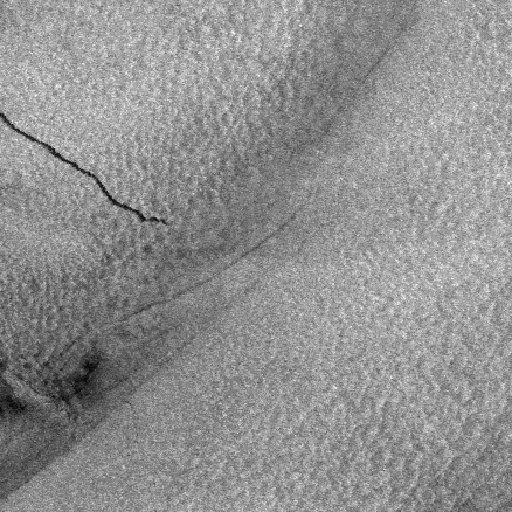

In [232]:
img_slick = Image.open(pth_slick)
autocontrast(img_slick, cutoff=0, ignore=None, mask=None, preserve_tone=False)

In [233]:
with open(pth_slick, 'rb') as f:
    byte_string = f.read()
    base64_string = base64.b64encode(byte_string).decode('utf-8')

payload = {"encoded_image": base64_string}

In [234]:
%%time
try:
    response = httpx.post(encode_url, json=payload, timeout=None)
except (BrokenPipeError, httpx.RemoteProtocolError, ConnectionResetError) as e:
    print("wait and try again")

CPU times: user 23.6 ms, sys: 6.71 ms, total: 30.3 ms
Wall time: 2.23 s


In [235]:
%%time
try:
    response = httpx.post(encode_url, json=payload, timeout=None)
except (BrokenPipeError, httpx.RemoteProtocolError, ConnectionResetError) as e:
    print("wait and try again")

CPU times: user 25.1 ms, sys: 3.93 ms, total: 29 ms
Wall time: 2.2 s


In [236]:
%%time
try:
    response = httpx.post(encode_url, json=payload, timeout=None)
except (BrokenPipeError, httpx.RemoteProtocolError, ConnectionResetError) as e:
    print("wait and try again")

CPU times: user 24 ms, sys: 3.48 ms, total: 27.5 ms
Wall time: 2.26 s


In [237]:
%%time
try:
    response = httpx.post(encode_url, json=payload, timeout=None)
except (BrokenPipeError, httpx.RemoteProtocolError, ConnectionResetError) as e:
    print("wait and try again")

CPU times: user 18.6 ms, sys: 7.33 ms, total: 25.9 ms
Wall time: 484 ms


In [238]:
encoded_embedding_string = response.json()['image_embedding']
base64_bytes = base64.b64decode(encoded_embedding_string)
image_embedding = np.frombuffer(base64_bytes, dtype=np.float32)
image_embedding

array([-0.13286641, -0.17649937, -0.17171675, ..., -0.1328539 ,
       -0.1372815 , -0.1409665 ], dtype=float32)

# BBox

In [239]:
img_shape = np.array(img_slick).shape
decode_payload = {
    "image_embeddings": encoded_embedding_string,
    "image_shape": img_shape[:2],
    "input_label": None,
    "input_point": None,
    "input_box": input_box,
}

# Point Click

In [213]:
img_shape = np.array(img_slick).shape
decode_payload = {
    "image_embeddings": encoded_embedding_string,
    "image_shape": img_shape[:2],
    "input_label": input_label,
    "input_point": input_points,
    "input_box": None,
}

In [240]:
%%time
decode_url="http://127.0.0.1:7080/predictions/sam_vit_h_decode"
response = httpx.post(decode_url, json=decode_payload, timeout=None)

response


CPU times: user 43.2 ms, sys: 2.4 ms, total: 45.6 ms
Wall time: 206 ms


<Response [200 ]>

In [241]:
encoded_masks_string = response.json()['masks']
base64_bytes_masks = base64.b64decode(encoded_masks_string)
masks = np.frombuffer(base64_bytes_masks, dtype=bool)

In [242]:
masks = masks.reshape((1,4,512,512))

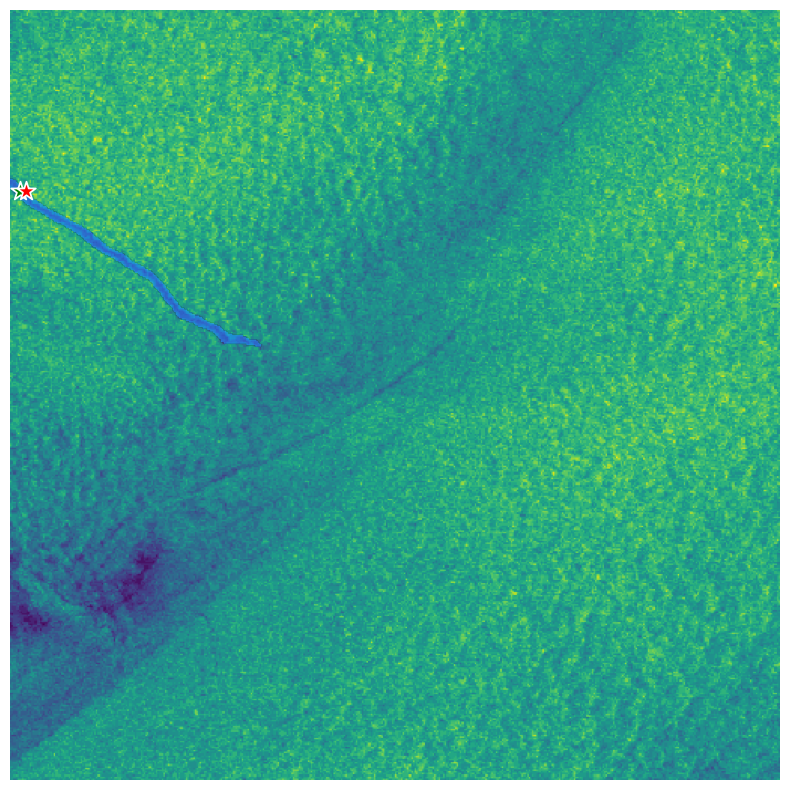

In [243]:
plt.figure(figsize=(10,10))
plt.imshow(np.array(img_slick))
show_mask(masks[0,1,:,:], plt.gca())
input_point_arr = np.array(input_points)[np.newaxis,:]
input_label_arr = np.array(input_label)[np.newaxis]
show_points(input_point_arr, input_label_arr, plt.gca())
plt.axis('off')
plt.show()